# Work Trial - Stefan Heimersheim

## Instructions
- [ ] Save a copy of this Colab notebook to your own drive  (File > Save a copy in Drive)
  - [ ] Update the sharing settings to "anyone with the link can comment."
- [ ] Create a separate Google doc to present your results and take notes, while completing the tasks in your copy of the Colab notebook.
  - [ ] Update the sharing settings to "anyone with the link can comment."
- [ ] Set a timer and start investigating. Do not spend more than 3 hours on this task. State the time spent on this work trial at the top of your Google doc.
- [ ] Submit both links in the MARS application.

# Background

This is a setting from one of my previous mentoring groups. We were investigating a variation of the model of "Compressed Computation" in [Braun et al. 2025](https://arxiv.org/abs/2501.14926) (section 3.2, no need to read).
The paper investigated a model that was able to learn 100 ReLU functions (labels) despite having only 50 neurons (actual ReLUs), when the inputs were sparse.

We generalized the setting and looked at non-sparse inputs. We want to see what the model learns if there is no sparsity. You will later see (Part 2) that this model _still_ does better than we naively expected. The naive expectation was that the MLP layer will simply ignore half of the features, and perfectly represent the other half. However, we found that, if the inputs are dense, the model achieves a lower loss than this (naive) model.

In this task I provide you with the trained model, and ask you to investigate what it's doing. Which features is it representing, what is it doing with the other ones, etc. Ultimately we want to figure out what "trick" the model is using to perform better than our naive expectation.

I do not expect you to conclude this investigation as part of the work trial. Instead consider this as a first step where you start the investigation, obtain some results, and present them to me (imagine sending a couple of Slack messages, or presenting your results at the next mentoring call).

# Setup code (imports)

In [1]:
import pickle
from dataclasses import dataclass
from pathlib import Path

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn

# Model & training code

The following code contains a mostly-standard MLP (but **without biases**) with a skip connection, i.e. a residual network. If you're familiar with transformers, this looks basically like a 1-layer transformer (without attention, and without the sequence dimension).

```
    x ∈ R^(batch x n_features)
         |
         v
    +----------+
    |   W_E    |  Embedding matrix (fixed)
    +----------+
         |
         v
    residual ∈ R^(batch x d_embed)
         |
         |------------+
         v            |
    +----------+      |
    |   W_in   |      |  MLP input weights (trainable)
    +----------+      |
         |            |
         v            |
    pre_act ∈ R^(batch x d_mlp)
         |            |
         v            |
    +----------+      |
    |   ReLU   |      |  ReLU activation
    +----------+      |
         |            |
         v            |
    post_act ∈ R^(batch x d_mlp)
         |            |
         v            |
    +----------+      |
    |  W_out   |      |  MLP output weights (trainable)
    +----------+      |
         |            |
         v            |
    mlp_out ∈ R^(batch x d_embed)
         |            |
         +<-----------+
         |
         v
    residual ∈ R^(batch x d_embed)
         |
         v
    +----------+
    |   W_E.T  |  Unembedding matrix (fixed)
    +----------+
         |
         v
    out ∈ R^(batch x n_features)
```

## Model and training code

The model code here should match the description above.

You don't need to read the training code.

In [2]:
@dataclass
class Config:
    """Configuration for the ResidualMLP model and training."""

    # Model parameters
    n_features: int = 100
    d_embed: int = 1000
    d_mlp: int = 50
    # Training parameters
    batch_size: int = 2048
    steps: int = 1_000
    lr: float = 3e-3
    print_freq: int = 50


class ResidualMLPModel(nn.Module):
    """A simple residual MLP model with fixed embeddings and one layer.

    Note that the model has no biases."""

    def __init__(self, config: Config):
        super().__init__()
        n_features, d_embed, d_mlp = config.n_features, config.d_embed, config.d_mlp
        # The embedding vectors are random unit vectors
        W_E = torch.randn(n_features, d_embed)
        W_E = F.normalize(W_E, dim=1)
        self.register_buffer("W_E", W_E)

        # The MLP weights are trained
        self.W_in = nn.Parameter(torch.empty(d_embed, d_mlp))
        self.W_out = nn.Parameter(torch.empty(d_mlp, d_embed))
        nn.init.xavier_normal_(self.W_in)
        nn.init.xavier_normal_(self.W_out)

    def forward(self, x: Tensor) -> Tensor:
        residual = einops.einsum(x, self.W_E, "batch n_features, n_features d_embed -> batch d_embed")
        pre_act = einops.einsum(residual, self.W_in, "batch d_embed, d_embed d_mlp -> batch d_mlp")
        post_act = F.relu(pre_act)
        mlp_out = einops.einsum(post_act, self.W_out, "batch d_mlp, d_mlp d_embed -> batch d_embed")
        residual = residual + mlp_out
        out = einops.einsum(residual, self.W_E, "batch d_embed, n_features d_embed -> batch n_features")
        return out


class UniformFeatureDataset:
    """Dataset of uniformly distributed features.

    The inputs X (batch x n_features) are uniformly distributed in the range [-1, 1]. The labels Y (batch x n_features) are X + ReLU(X).
    """

    def __init__(self, config: Config):
        self.n_features = config.n_features

    def generate_batch(self, batch_size: int, resid: bool = True) -> tuple[Tensor, Tensor]:
        batch = 2 * torch.rand((batch_size, self.n_features)) - 1
        labels = F.relu(batch) + batch
        return batch, labels


def train(config: Config, model: ResidualMLPModel, dataset: UniformFeatureDataset) -> None:
    torch.manual_seed(42)
    np.random.seed(42)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
    dataset = UniformFeatureDataset(config)

    for step in range(config.steps):
        batch, labels = dataset.generate_batch(config.batch_size)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1))
        loss.backward()
        optimizer.step()

        if step % config.print_freq == 0 or step == config.steps - 1:
            print(f"Step {step} loss: {loss.item():.2e}")

    return model


def evaluate(model: ResidualMLPModel, dataset: UniformFeatureDataset, batch_size: int = 10_000) -> float:
    with torch.no_grad():
        batch, labels = dataset.generate_batch(batch_size)
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1)).item()
    return loss

# Training
The following cell runs the training code (should take less than a minute, you can just use a CPU).

It should automatically load the model the 2nd time you run this cell, otherwise adjust the code below.

In [3]:
config = Config(steps=500, batch_size=2048)

model_path = Path("model.pkl")
if not model_path.exists():
    model = ResidualMLPModel(config)
    dataset = UniformFeatureDataset(config)
    train(config, model, dataset)
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
else:
    with open(model_path, "rb") as f:
        model = pickle.load(f)
        dataset = UniformFeatureDataset(config)

print("Trained model loss:", evaluate(model, dataset))

Trained model loss: 0.0554874911904335


# Task (part 1)

This model has only 50 neurons, but we trained it on 100 input features. We want to see what the model has learned.

In this exercise I want to test how well you can iterate on results and find good ways to extract and present information. The suggestions below are what I might say during a mentoring call. You don't have to stick to them exactly, and you don't have to stop there!

> I think we should start by measuring the loss per feature (for the different features), can you plot this? And can you plot the input-output response for each feature (where input feature = output feature), maybe in isolation (only that feature non-zero) or together with other features active.



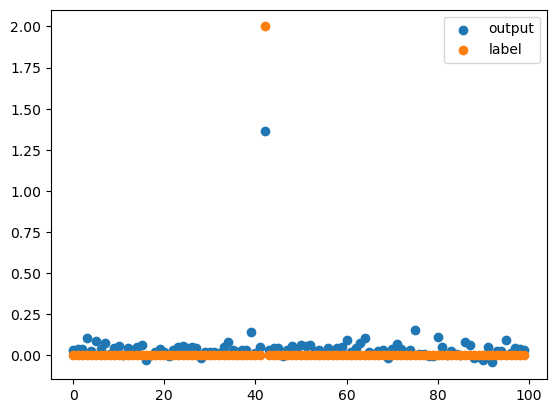

In [4]:
# Example code how you might interact with the model
batch_size = 1
batch = torch.zeros(batch_size, config.n_features)
batch[:, 42] = 1
label = F.relu(batch) + batch
out = model(batch).detach()
plt.scatter(np.arange(config.n_features), out[0], label="output")
plt.scatter(np.arange(config.n_features), label[0], label="label")
plt.legend()
plt.show()

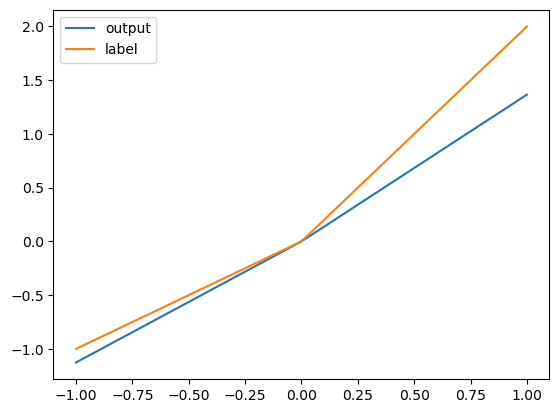

In [5]:
# Plot the input output response for feature 42
batch_size = 100
batch = torch.zeros(batch_size, config.n_features)
x = torch.linspace(-1, 1, batch_size)
batch[:, 42] = x
label = F.relu(batch) + batch
out = model(batch).detach()

plt.plot(x, out[:, 42], label="output")
plt.plot(x, label[:, 42], label="label")
plt.legend()
plt.show()

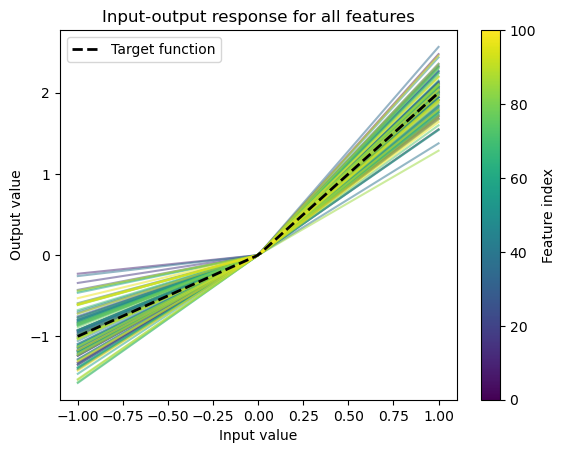

In [6]:
batch_size = 100
x = torch.linspace(-1, 1, batch_size)
batch = torch.zeros(batch_size, config.n_features)

for i in range(config.n_features):
    batch[:, i] = x

label = F.relu(batch) + batch
with torch.no_grad():
    out = model(batch)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=config.n_features)

for i in range(config.n_features):
    plt.plot(x, out[:, i], c=cmap(norm(i)), alpha=0.5)
    
plt.plot(x, F.relu(x) + x, 'k--', label='Target function', linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca(), label='Feature index')
plt.xlabel('Input value')
plt.ylabel('Output value') 
plt.title('Input-output response for all features')
plt.legend()
plt.show()

/var/folders/lq/6ygf18dd0sn75g2htdh556cw0000gn/T/ipykernel_37846/3802717160.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


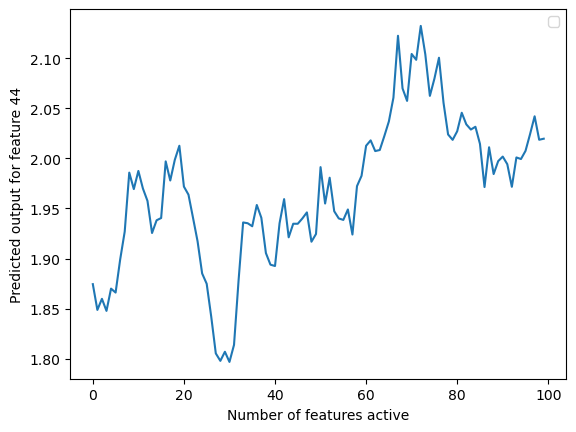

In [7]:
# Are predictions for features made in isolation? Does the value of other features affect the prediction of feature 42?

feature_index = 44
batch_size = 100 # for incrementally activating features
batch = torch.zeros(batch_size, config.n_features) # take loss at 10 values of feature 42 and sum
batch[:, feature_index] = 1

for i in range(config.n_features):
    batch[i, :i] = 1

with torch.no_grad():
    out = model(batch)

plt.plot(out[:, feature_index])
plt.xlabel("Number of features active")
plt.ylabel(f"Predicted output for feature {feature_index}")
plt.legend()
plt.show()

/var/folders/lq/6ygf18dd0sn75g2htdh556cw0000gn/T/ipykernel_37846/1413960352.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


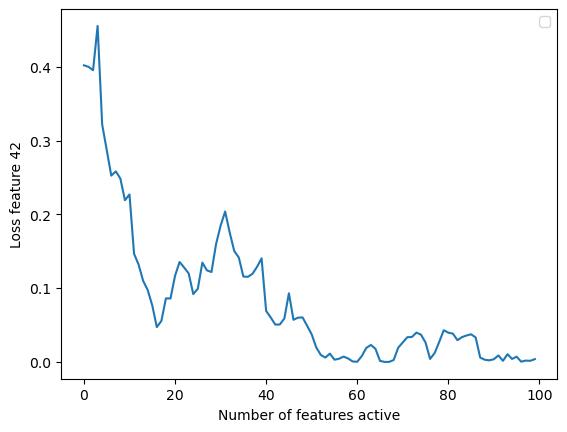

In [8]:
batch_size = 100 # for incrementally activating features
batch = torch.zeros(batch_size, config.n_features) # take loss at 10 values of feature 42 and sum
batch[:, 42] = 1

for i in range(config.n_features):
    batch[i, :i] = 1

with torch.no_grad():
    out = model(batch)
    loss = (out[:, 42] - 2) ** 2

plt.plot(loss)
plt.xlabel("Number of features active")
plt.ylabel("Loss feature 42")
plt.legend()
plt.show()

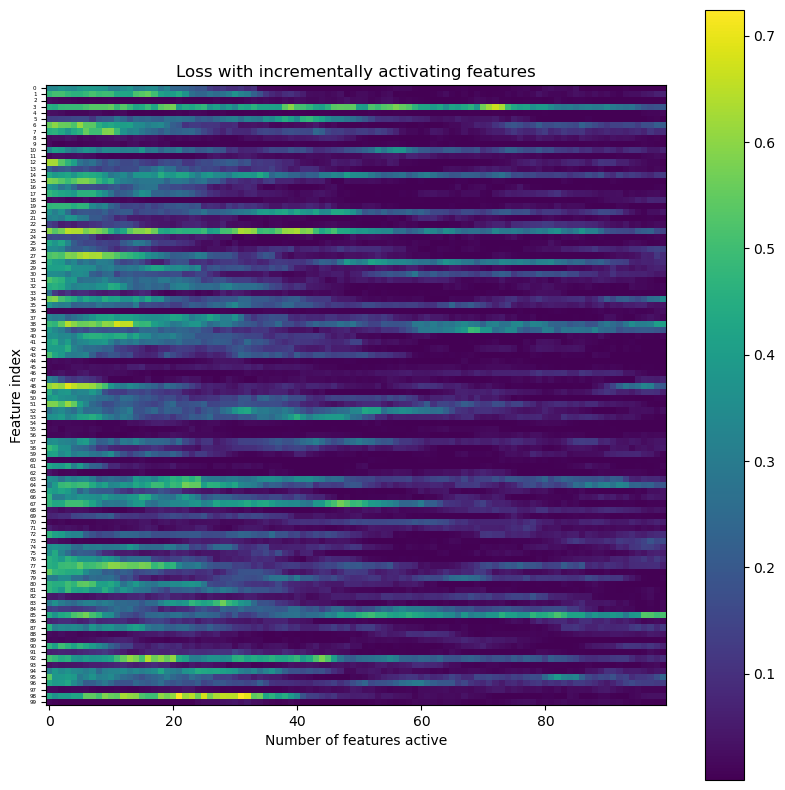

In [9]:
# Plot all feature losses as other features are activated
n_features = 100
batch_size = 100 # for incrementally activating features
x = torch.zeros(n_features, batch_size, config.n_features) # take loss at 10 values of feature 42 and sum

for feature in range(n_features):
    x[feature, :, feature] = 1

    for i in range(config.n_features):
        x[feature, i, :i] = 1

losses = torch.zeros(n_features, n_features)

for feature in range(n_features):
    with torch.no_grad():
        out = model(x[feature])
        loss = (out[:, feature] - 2) ** 2
        losses[feature, :] = loss

plt.figure(figsize=(10, 10))
plt.imshow(losses)
plt.title("Loss with incrementally activating features")
plt.xlabel("Number of features active")
plt.yticks(range(0, 100, 1), fontsize=4)

plt.ylabel("Feature index")
plt.colorbar()
plt.show()

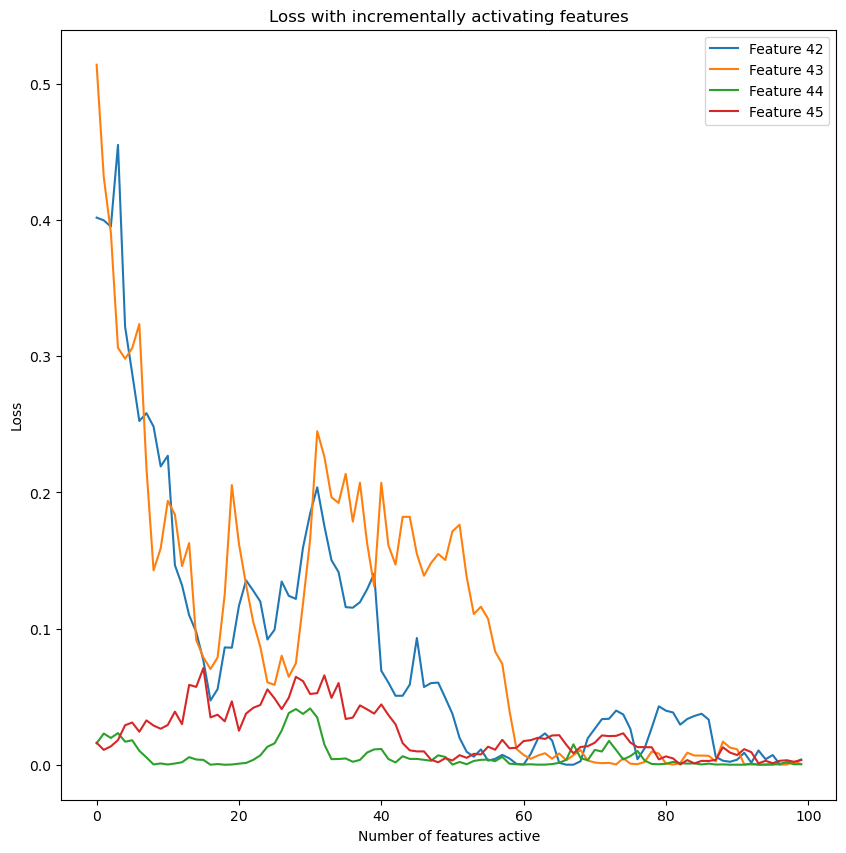

In [10]:
features_to_plot = [42, 43, 44, 45]
plt.figure(figsize=(10, 10))
for feature in features_to_plot:
    plt.plot(losses[feature, :], label=f"Feature {feature}")
plt.xlabel("Number of features active")
plt.ylabel(f"Loss")
plt.legend()
plt.title("Loss with incrementally activating features")
plt.show()

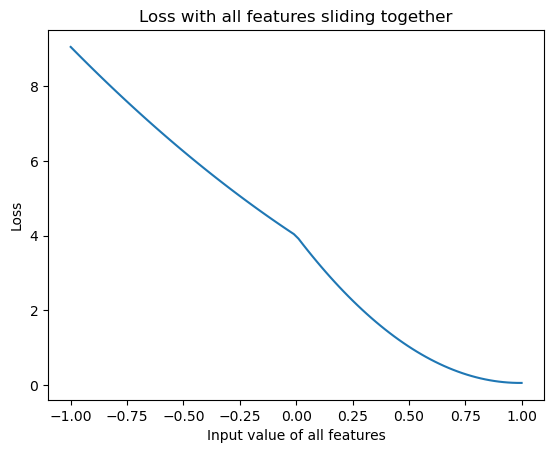

In [11]:
# How does loss change as all features slide together from -1 to 1?
batch_size = 100
batch = torch.zeros(batch_size, config.n_features)
x = torch.linspace(-1, 1, 100)

for b in range(batch_size):
    batch[b, :] = x[b]

with torch.no_grad():
    out = model(batch)
    loss = ((out - 2) ** 2).mean(dim=1)

plt.plot(x, loss)
plt.xlabel("Input value of all features")
plt.ylabel("Loss")
plt.title("Loss with all features sliding together")
plt.show()

Loss of feature 44 when activated alone: 0.015773827210068703


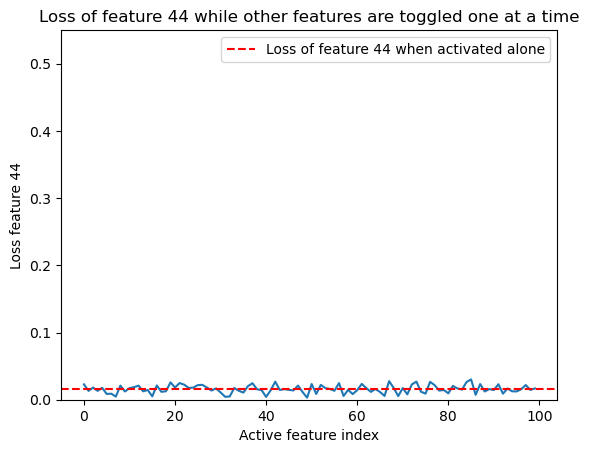

tensor(49)

In [12]:
# Plot the loss of feature 42 when activated alone
feature_index = 44
batch_size = 1
batch = torch.zeros(1, config.n_features) # take loss at 10 values of feature 42 and sum
batch[:, feature_index] = 1

with torch.no_grad():
    out = model(batch)
    loss_feature_alone = (out[:, feature_index] - 2) ** 2

print(f"Loss of feature {feature_index} when activated alone:", loss_feature_alone.item())

# Plot the loss of feature 42 while other features are toggled one at a time
batch_size = 100
batch = torch.zeros(batch_size, config.n_features) # take loss at 10 values of feature 42 and sum
batch[:, feature_index] = 1

for i in range(batch_size):
    batch[i, i] = 1

with torch.no_grad():
    out = model(batch)
    loss = (out[:, feature_index] - 2) ** 2

plt.plot(loss)
plt.axhline(y=loss_feature_alone.item(), linestyle='--', color='red', label=f'Loss of feature {feature_index} when activated alone')
plt.xlabel("Active feature index")
plt.ylabel(f"Loss feature {feature_index}")
plt.title(f"Loss of feature {feature_index} while other features are toggled one at a time")
plt.ylim(0, 0.55)
plt.legend()
plt.show()
loss.argmin() # 42

Cosine similarities shape: torch.Size([50, 100])


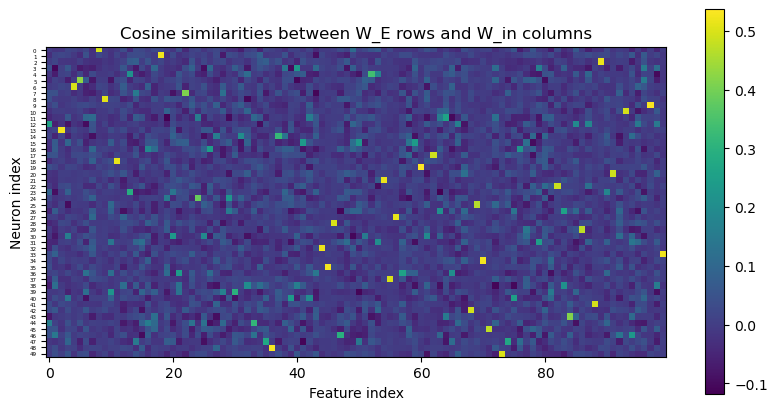

In [13]:
# Calculate cosine similarities between W_E rows and W_in columns
# Normalize W_E rows and W_in columns first
W_E_norm = F.normalize(model.W_E, dim=1)  # Shape: 100x1000
W_in_norm = F.normalize(model.W_in, dim=0) # Shape: 1000x50

# Calculate similarities using matrix multiplication
# (100x1000) @ (1000x50) = (100x50)
with torch.no_grad():
    similarities = torch.matmul(W_E_norm, W_in_norm).cpu() # Shape: 100x50

# Transpose to get desired 50x100 shape
similarities = similarities.T

print("Cosine similarities shape:", similarities.shape)
plt.figure(figsize=(10,5))
plt.imshow(similarities)
plt.colorbar()
plt.title("Cosine similarities between W_E rows and W_in columns")
plt.ylabel("Neuron index")
plt.xlabel("Feature index")
plt.yticks(range(0, 50, 1), fontsize=4)
plt.show()

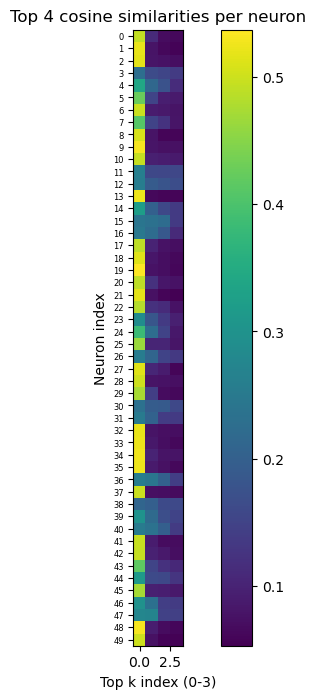

In [14]:
# Choose four feature indices with the highest cosine similarities

top_4_indices = torch.topk(similarities, k=4, dim=1).indices.cpu()
top_4_values = torch.topk(similarities, k=4, dim=1).values.cpu()

plt.figure(figsize=(10,8))
plt.imshow(top_4_values)
plt.colorbar()
plt.title("Top 4 cosine similarities per neuron")
plt.xlabel("Top k index (0-3)")
plt.ylabel("Neuron index")
plt.yticks(range(0, 50, 1), fontsize=6)
plt.show()

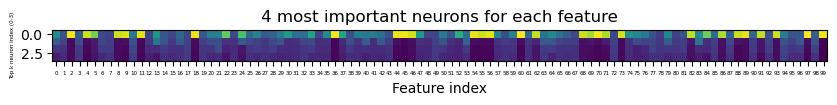

In [15]:
# Show the most important 4 neurons for feature indices

top_4_indices = torch.topk(similarities, k=4, dim=0).indices.cpu()
top_4_values = torch.topk(similarities, k=4, dim=0).values.cpu()

plt.figure(figsize=(10,8))
plt.imshow(top_4_values)
plt.title("4 most important neurons for each feature")
plt.ylabel("Top k neuron index (0-3)", fontsize=4)
plt.xlabel("Feature index")
plt.xticks(range(0, 100, 1), fontsize=4)
plt.show()

Cosine similarities shape: torch.Size([50, 100])


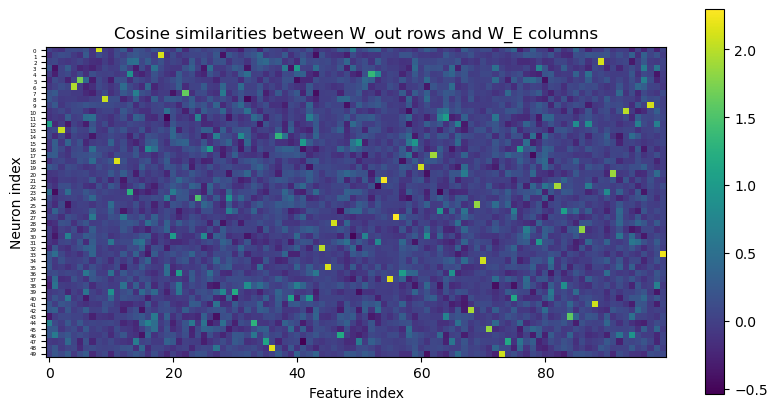

In [16]:
# Show the cosine similarities for output weights and unembedding matrix

# Normalize W_E rows and W_out columns first
W_E_norm = F.normalize(model.W_E, dim=1)  # Shape: 100x1000
W_out_norm = F.normalize(model.W_out, dim=0) # Shape: 1000x50

# Calculate similarities using matrix multiplication
# (100x1000) @ (1000x50) = (100x50)
with torch.no_grad():
    out_similarities = einops.einsum(W_out_norm, W_E_norm, "n_neurons_out d_embed, n_features d_embed -> n_neurons_out n_features")


print("Cosine similarities shape:", out_similarities.shape)
plt.figure(figsize=(10,5))
plt.imshow(out_similarities)
plt.colorbar()
plt.title("Cosine similarities between W_out rows and W_E columns")
plt.ylabel("Neuron index")
plt.xlabel("Feature index")
plt.yticks(range(0, 50, 1), fontsize=4)
plt.show()

# Task (part 2)

In [17]:
class NaiveSolution(nn.Module):
    """A simple ResidualMLP model with no embeddings (W_E = I) and identity MLP weights"""

    def __init__(self, config: Config):
        super().__init__()
        self.W_in = nn.Parameter(torch.eye(config.n_features, config.d_mlp))
        self.W_out = nn.Parameter(torch.eye(config.d_mlp, config.n_features))

    def forward(self, x: Tensor) -> Tensor:
        pre_act = einops.einsum(x, self.W_in, "batch n_features, n_features d_mlp -> batch d_mlp")
        post_act = F.relu(pre_act)
        out = einops.einsum(post_act, self.W_out, "batch d_mlp, d_mlp n_features -> batch n_features")
        return out + x


naive_model = NaiveSolution(config)
print("Naive model loss:", evaluate(naive_model, dataset))

Naive model loss: 0.0835920050740242


In [18]:
# Define a model with ability to ablate neurons
class ResidualMLPModelAblate(nn.Module):
    """A simple residual MLP model with fixed embeddings and one layer.
    
    Takes a base model and ablates specified neurons during forward pass."""

    def __init__(self, base_model: ResidualMLPModel):
        super().__init__()
        self.bm = base_model

    def forward(self, x: Tensor, neuron_idx: int = None) -> Tensor:
        residual = einops.einsum(x, self.bm.W_E, "batch n_features, n_features d_embed -> batch d_embed")
        pre_act = einops.einsum(residual, self.bm.W_in, "batch d_embed, d_embed d_mlp -> batch d_mlp")
        post_act = F.relu(pre_act)
        
        # Ablate specified neuron if provided
        if neuron_idx is not None:
            post_act[:, neuron_idx] = 0
            
        mlp_out = einops.einsum(post_act, self.bm.W_out, "batch d_mlp, d_mlp d_embed -> batch d_embed")
        residual = residual + mlp_out
        out = einops.einsum(residual, self.bm.W_E, "batch d_embed, n_features d_embed -> batch n_features")
        return out

ablatable_model = ResidualMLPModelAblate(model)

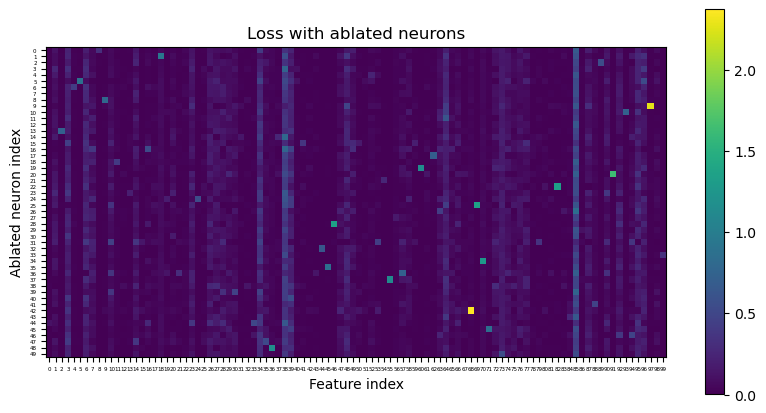

In [19]:
batch_size = 1
batch = torch.ones(batch_size, config.n_features)
ablated_losses = torch.zeros(config.d_mlp, config.n_features)

for neuron_idx in range(config.d_mlp):
    with torch.no_grad():
        out = ablatable_model(batch, neuron_idx)
        loss = ((out - 2) ** 2).mean(dim=0)
        ablated_losses[neuron_idx, :] = loss

plt.figure(figsize=(10, 5))
plt.imshow(ablated_losses)
plt.colorbar()
plt.title("Loss with ablated neurons")
plt.ylabel("Ablated neuron index")
plt.xlabel("Feature index")
plt.yticks(range(0, 50, 1), fontsize=4)
plt.xticks(range(0, 100, 1), fontsize=4)
plt.show()

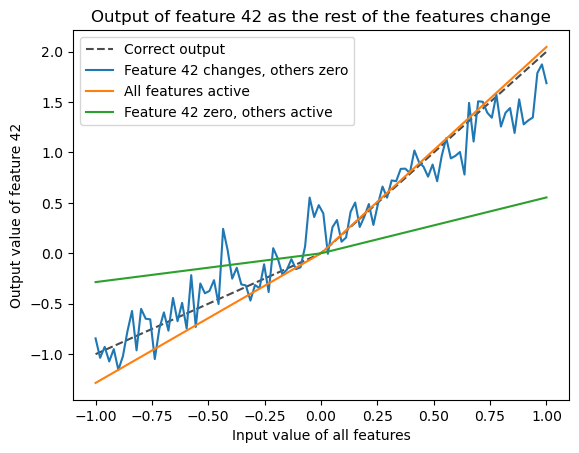

In [20]:
# What is the output of a dead feature, e.g. feature 42, as the rest of the features change?

feature_index = 42
batch_size = 100
batch = torch.zeros(batch_size, config.n_features)
x = torch.linspace(-1, 1, 100)

for b in range(batch_size):
    batch[:, b] = x


with torch.no_grad():
    out_with_feature = model(batch)
    only_feature = model(batch[:, feature_index].unsqueeze(0))
    batch[:, feature_index] = 0
    out_without_feature = model(batch)

correct_output = F.relu(x) + x
plt.plot(x, correct_output, '--', label="Correct output", color='black', alpha=0.7)
plt.plot(x, only_feature.squeeze(), label=f"Feature {feature_index} changes, others zero")
plt.plot(x, out_with_feature[:, feature_index], label=f"All features active")
plt.plot(x, out_without_feature[:, feature_index], label=f"Feature {feature_index} zero, others active")
plt.legend()
plt.xlabel("Input value of all features")
plt.ylabel("Output value of feature 42")
plt.title("Output of feature 42 as the rest of the features change")
plt.show()

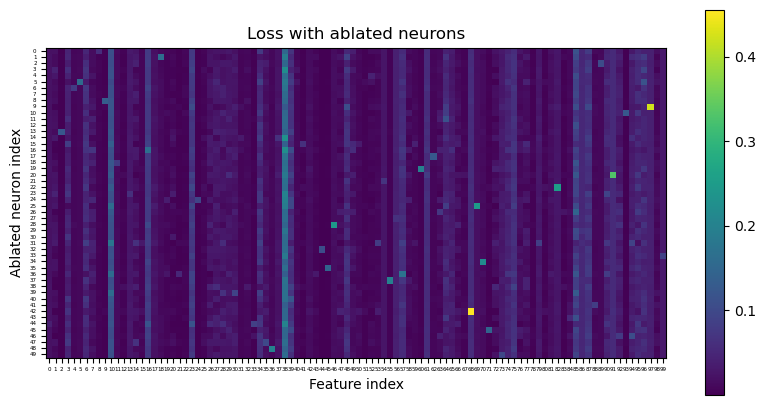

In [21]:
batch_size = 100
x = torch.linspace(-1, 1, 100)
batch = torch.zeros(batch_size, config.n_features)

for b in range(batch_size):
    batch[:, b] = x

ablated_losses = torch.zeros(config.d_mlp, config.n_features)
y = batch + F.relu(batch)

for neuron_idx in range(config.d_mlp):
    with torch.no_grad():
        out = ablatable_model(batch, neuron_idx)
        loss = ((out - y) ** 2).mean(dim=0)
        ablated_losses[neuron_idx, :] = loss

plt.figure(figsize=(10, 5))
plt.imshow(ablated_losses)
plt.colorbar()
plt.title("Loss with ablated neurons")
plt.ylabel("Ablated neuron index")
plt.xlabel("Feature index")
plt.yticks(range(0, 50, 1), fontsize=4)
plt.xticks(range(0, 100, 1), fontsize=4)
plt.show()


The model we trained appears to achieve a better loss than the naive solution (representing just half the features, which should get a loss of 0.0833). How does it do that? What is it doing?

> I would generally like to check how the model loss scales with number of active features. (In the training dataset all features were active, but we can just run the model with all features except for some set to 0.) Can you plot the "average loss per feature" (that is just loss divided by fraction of active features), as a function of number of active features?

> And after that, maybe check if there's any pattern in the input-output response of the "cross-terms", i.e. where input feature != output feature?